In [1]:

import numpy as np
import roadrunner
from scipy import io
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import math

import pypesto
import pypesto.engine as eng
import pypesto.visualize as visualize
import pypesto.optimize as optimize
import pypesto.profile as profile
import pypesto.sample as sample
import pypesto.store as store
from pypesto.ensemble import Ensemble
import os 

SEED=123456
np.random.seed(seed=SEED)
engine = eng.MultiProcessEngine(n_procs=os.cpu_count())

print(os.cpu_count())

10


In [2]:
mrnaSBML = "myImplemt.xml" # name of sbml file
rr = roadrunner.RoadRunner(mrnaSBML)

In [3]:
# model system params
NFkB_SBML = "myImplemt.xml" # name of sbml file 
# species = ["nNFKB", "cNFKB", "cikba", "Ccomplex", "nikba", "ncomplex", "ikkN", "ikka", "TNFR_a", "TNFR_i", "TNF"] # names of observables in order from bngl file, also in smbl under "dependent variables / observables"
species = ["TNF", "TNFRi", "TNFRa", "IKKi", "IKKa", "cNFKB", "nNFKB", "cIkB", "nIkB", "cNFkB_IkB", "nNFkB_IkB", "A20"] # names of observables in order from bngl file, also in smbl under "dependent variables / observables"

speciesID = ["S1", "S2", "S3", "S4", "S5", "S6", "S7", "S8", "S9", "S10", "S11", "S12"] # these are the IDs created from the sbml file 
time = 300 # t_end from bngl 
SPECIES_COLORS = ["tab:pink", "tab:purple", "tab:cyan", "tab:blue", "tab:orange", "tab:green", "tab:red", "tab:gray", "tab:brown", "tab:olive", "black", "y"]
# params = ["k_b", "k_f", "k_a", "k_4", "ka1a", "kd1a", "ki1", "ke1", "ki2", "ke2", "ke2a", "c4a", "c5a", "kt1a", "kt2a", "c1a"] # names of parameters in order from bngl file 
params = ["LOG_k_b", "LOG_k_f", "LOG_k_a", "LOG_k_4", "LOG_k_i1", "LOG_k_e1", "LOG_k_t2a", "LOG_k_t1a", "LOG_k_i2", "LOG_k_e2", "LOG_k_e2a", "LOG_c_4a", "LOG_c_5a", "LOG_c_1a", "LOG_k_a1a", "LOG_k_d1a", "LOG_c_3", "LOG_c_1", "LOG_k_ikk", "LOG_k_tnfr", "LOG_TNFRin", "LOG_IKKin", "LOG_boundc"] # names of parameters in order from bngl file 

# synthetic data params
gausNoise = 0.01 # 1% gausian noise, should it be 10% noise? i do 10 later
points = 301 # not sure yet 

# optimizaiton params 
logError = False

In [4]:
NFkB_SBML = "myImplemt.xml" # name of sbml file
rr = roadrunner.RoadRunner(NFkB_SBML) # uses libroadrunner to load the sbml file for the mRNA model 
# integrator is a numerical ODE solver
# abs and rel tolerance are parameters controlling error tolerence of the solution
rr.integrator.absolute_tolerance = 5e-12 # in absolute terms:  small value increases accuracy but slower
rr.integrator.relative_tolerance = 1e-12 # rel terms (proportion of value being calc): small val inc acc

# list of the true parameter values 
trueParams = [rr[params[0]], rr[params[1]], rr[params[2]], rr[params[3]], rr[params[4]], rr[params[5]], rr[params[6]], rr[params[7]], rr[params[8]], rr[params[9]], rr[params[10]], rr[params[11]],rr[params[12]], rr[params[13]], rr[params[14]], rr[params[15]]] ,rr[params[16]], rr[params[17]], rr[params[18]], rr[params[19]], rr[params[20]], rr[params[21]], rr[params[22]]


In [5]:
print(trueParams)

([0.0352, -3.0688, -4.5164, -7.4173, -2.057, -5.9334, -8.0, -7.3178, -4.1089, -10.6289, -3.5859, -4.6363, -4.6, -3.2082, -7.0, -8.0], -20.0, -20.0, -20.0, -20.0, 2.5258, 4.7454, 6.5546)


res         time, [S1],      [S2],    [S3],    [S4],    [S5],    [S6],       [S7],       [S8],        [S9],       [S10],       [S11],       [S12]
 [[        0,    5,   335.583,       0, 55641.7,       0,       0,          0,          0,           0, 3.58592e+06,           0,           0],
  [ 0.100033,    5,   195.098, 140.485, 55628.7,  12.975, 9.02622, 0.00395644, 0.00358717, 1.39625e-08, 3.58591e+06,  3.6464e-19, 1.31888e-24],
  [ 0.200067,    5,   113.434, 222.149, 55597.3,  44.313, 18.1269,  0.0158594, 0.00717478, 5.58516e-08,  3.5859e+06, 1.16866e-17, 1.05646e-23],
  [   0.3001,    5,   65.9618, 269.621, 55555.3, 86.3008, 27.3528,  0.0357985,  0.0107633, 1.25673e-07, 3.58589e+06, 8.89588e-17, 3.57275e-23],
  [ 0.400133,    5,    38.366, 297.217, 55507.2, 134.452, 36.7332,  0.0638976,  0.0143533, 2.23435e-07, 3.58588e+06, 3.76024e-16, 8.49062e-23],
  [ 0.500167,    5,   22.3245, 313.259, 55455.5,  186.16, 46.2849,     0.1003,  0.0179452, 3.49152e-07, 3.58587e+06, 1.15165e-15, 1.66

Text(0.5, 1.0, 'True Solution for NF-kB Model (my Implementation)')

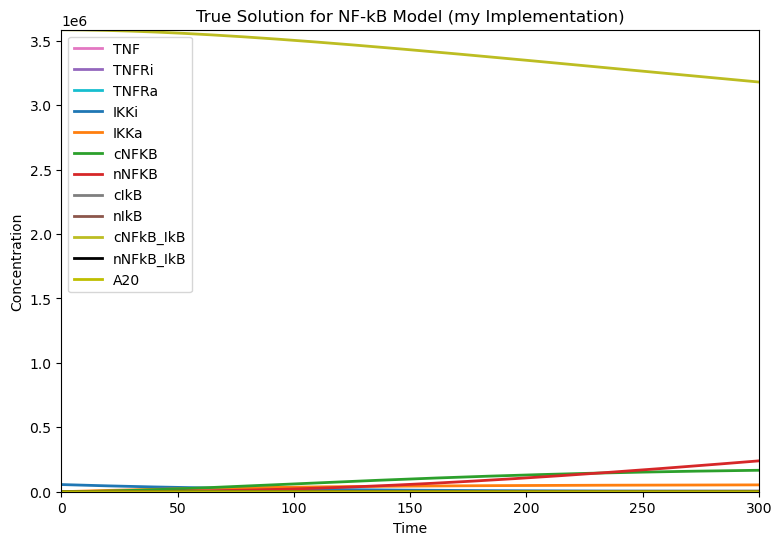

In [6]:
plt.figure(figsize=(9,6), dpi=100)
# simulates model from 0 to time with time*10 # of points
# in res: first col rep time points, other cols rep the trajectories (value over time) of species in model 
res = rr.simulate(0, time, time*10)  
ts = res[:,0] # first col in res is the time points 
trajs = np.transpose(res[:,1:]) # rest of cols, so trajs has species as rows and time as cols bc transposed

print("res", res)
# print("trajs", trajs)

for label, color, traj in zip(species, SPECIES_COLORS, trajs):
    plt.plot(ts, traj, color=color, label=label, lw=2)

plt.legend()
plt.margins(x=0, y=0)
plt.xlabel("Time")
plt.ylabel("Concentration")
plt.title("True Solution for NF-kB Model (my Implementation)")

Text(0.5, 1.0, 'Solution for TNF-NF-kB Model')

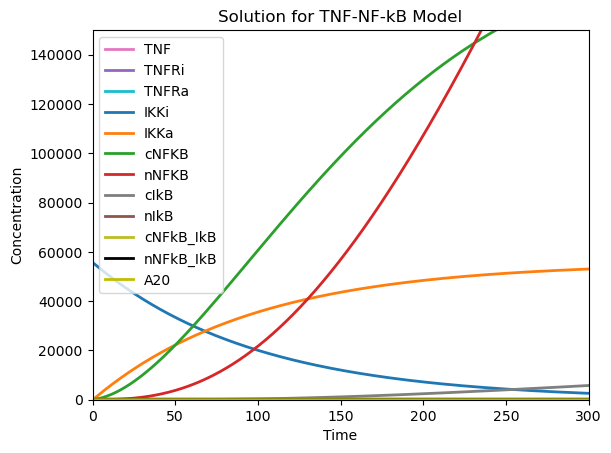

In [8]:
# use this one to edit figure

for label, color, traj in zip(species, SPECIES_COLORS, trajs):
    plt.plot(ts, traj, color=color, label=label, lw=2)

plt.legend()
plt.margins(x=0, y=0)
plt.ylim(0,150000)
plt.xlabel("Time")
plt.ylabel("Concentration")
plt.title("Solution for TNF-NF-kB Model")

Text(0.5, 1.0, 'True Solution for nNFKB')

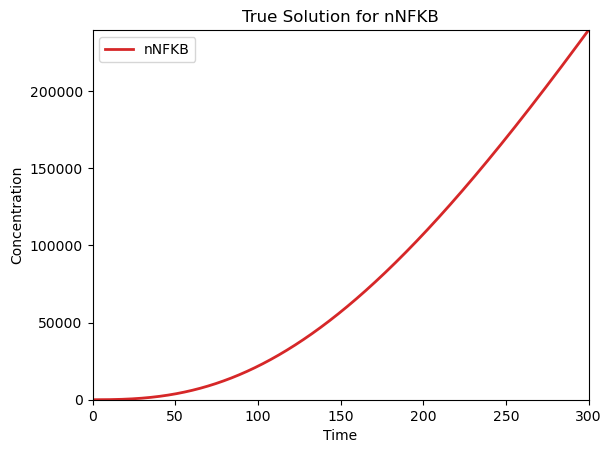

In [24]:
# only plotting the mRNA concentration to compare to the paper 
# species = ["TNF", "TNFRi", "TNFRa", "IKKi", "IKKa", "cNFKB", "nNFKB", "cIkB", "nIkB", "cNFkB_IkB", "nNFkB_IkB", "A20"] 

plt.plot(ts, trajs[6,], label = "nNFKB", color = "tab:red", lw=2)
plt.legend()
plt.margins(x=0, y=0)
# plt.ylim(0,5)
#plt.ylim(0,30)
plt.xlabel("Time")

plt.ylabel("Concentration")
plt.title("True Solution for nNFKB")

Text(0.5, 1.0, 'True Solution for nNFKB')

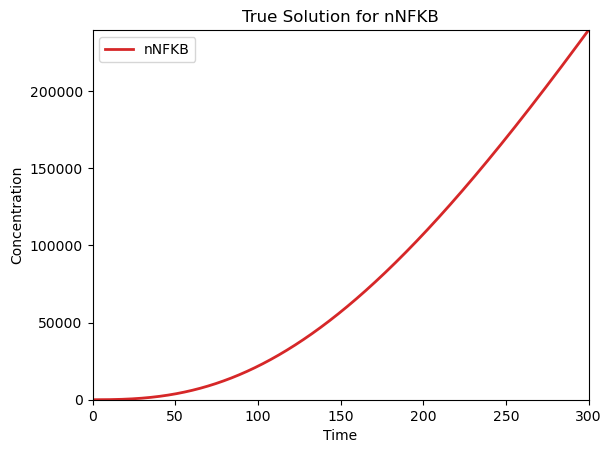

In [25]:
# only plotting the mRNA concentration to compare to the paper 
# species = ["TNF", "TNFRi", "TNFRa", "IKKi", "IKKa", "cNFKB", "nNFKB", "cIkB", "nIkB", "cNFkB_IkB", "nNFkB_IkB", "A20"] 

plt.plot(ts, trajs[6,], label = "nNFKB", color = "tab:red", lw=2)
plt.legend()
plt.margins(x=0, y=0)
# plt.ylim(0,5)
#plt.ylim(0,30)
plt.xlabel("Time")

plt.ylabel("Concentration")
plt.title("True Solution for nNFKB")

Generating Data

In [26]:
rr.resetAll() # reset everything so we can start over and use our noisy data 

# simulates model from 0 to time with # of points
# in res: first col rep time points, other cols rep the trajectories (value over time) of species in model 
simData = rr.simulate(0, time, points)  
tsSim = simData[:,0] # first col in res is the time points 
print(tsSim)
trajsSim = simData[:,7] # the second col bc we want the mRNA concentration
print(trajsSim)

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.
 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139.
 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153.
 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167.
 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179. 180. 181.
 182. 183. 184. 185. 186. 187. 188. 189. 190. 191. 192. 193. 194. 195.
 196. 

In [27]:
df = pd.DataFrame()
df['time'] = tsSim
df['nNFkB'] = trajsSim
df.to_csv('NFkB_sim_data.csv', index=False)

Text(0.5, 1.0, 'Comparing Original and Synthetic Data with 1 Percent Gaussian Noise')

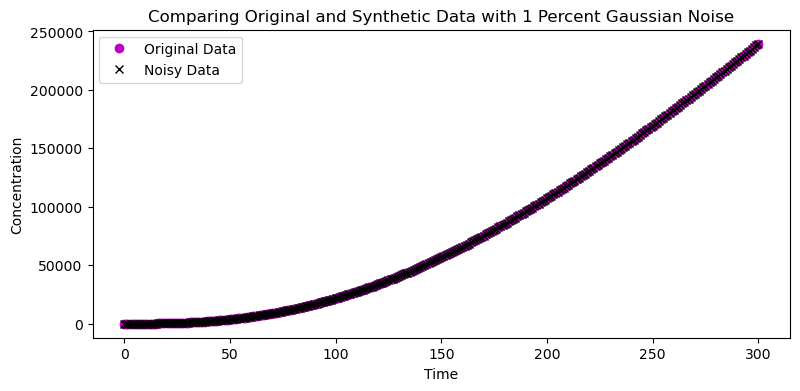

In [33]:
plt.figure(figsize=(9,4), dpi=100)
plt.plot(tsSim, trajsSim, 'om', label = "Original Data")
plt.plot(tsSim, trajsSim, 'kx', label = "Noisy Data")

plt.legend()
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('Comparing Original and Synthetic Data with 1 Percent Gaussian Noise')

With Gaussian Noise

In [34]:
def gaussianNoise(x, std, mean=0):
    
    gNoise = np.random.normal(mean, std, size = x.shape) # creates a gaussian dist the size of our data
    xNoise = x + gNoise # adds noise to our data

    # will return noisy data
    return xNoise 

In [37]:
rr.resetAll() # reset everything so we can start over and use our noisy data 

# simulates model from 0 to time with # of points
# in res: first col rep time points, other cols rep the trajectories (value over time) of species in model 
resNoise = rr.simulate(0, time, points)  
tsNoise = resNoise[:,0] # first col in res is the time points 
print(tsNoise)
trajsNoise = resNoise[:,7] # the second col bc we want the mRNA concentration
print(trajsNoise)

std = gausNoise * np.std(trajsNoise)
onePercentNoise = gaussianNoise(trajsNoise, std)

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.
 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139.
 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153.
 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167.
 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179. 180. 181.
 182. 183. 184. 185. 186. 187. 188. 189. 190. 191. 192. 193. 194. 195.
 196. 

In [38]:
print(resNoise)

    time, [S1],      [S2],    [S3],    [S4],    [S5],    [S6],     [S7],      [S8],        [S9],       [S10],       [S11],       [S12]
 [[    0,    5,   335.583,       0, 55641.7,       0,       0,        0,         0,           0, 3.58592e+06,           0,           0],
  [    1,    5,   1.53383, 334.049, 55179.4, 462.202, 96.8011, 0.412181, 0.0359404, 1.39686e-06, 3.58582e+06, 3.76252e-14, 1.35488e-21],
  [    2,    5, 0.0593527, 335.524,   54619, 1022.66,   212.2,   1.7532, 0.0724078, 5.60746e-06,  3.5857e+06, 1.26966e-12, 1.13384e-20],
  [    3,    5, 0.0528444,  335.53, 54063.8, 1577.87, 346.506,  4.18944,  0.110026, 1.26964e-05, 3.58556e+06, 1.01904e-11,   4.007e-20],
  [    4,    5, 0.0528157,  335.53, 53514.2, 2127.44, 499.353,  7.88511,  0.149519, 2.27807e-05, 3.58541e+06, 4.53958e-11, 9.93257e-20],
  [    5,    5, 0.0528155,  335.53, 52970.2, 2671.42, 670.376,  13.0012,  0.191714, 3.60378e-05, 3.58523e+06, 1.46446e-10, 2.02507e-19],
  [    6,    5, 0.0528155,  335.53, 52431.8

In [39]:
df = pd.DataFrame()
df['time'] = tsNoise
df['nNFkB'] = onePercentNoise
df.to_csv('onePercNoise_NFkB_data.csv', index=False)

Text(0.5, 1.0, 'Comparing Original and Synthetic Data with 1 Percent Gaussian Noise')

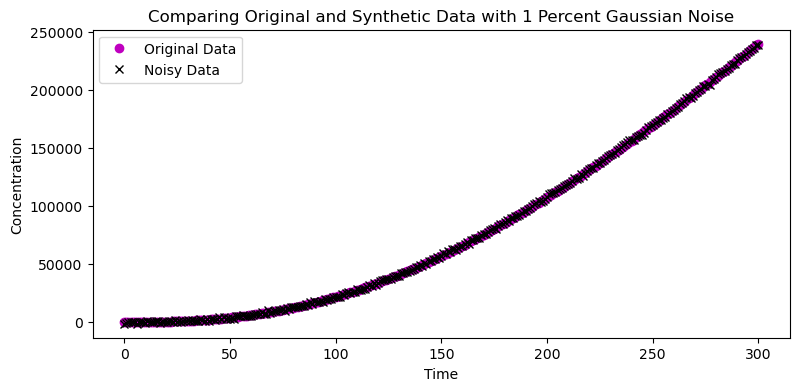

In [40]:
plt.figure(figsize=(9,4), dpi=100)
plt.plot(tsNoise, trajsNoise, 'om', label = "Original Data")
plt.plot(tsNoise, onePercentNoise, 'kx', label = "Noisy Data")

plt.legend()
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('Comparing Original and Synthetic Data with 1 Percent Gaussian Noise')

10% Noise

In [41]:
rr.resetAll() # reset everything so we can start over and use our noisy data 

# simulates model from 0 to time with # of points
# in res: first col rep time points, other cols rep the trajectories (value over time) of species in model 
resNoise = rr.simulate(0, time, points)  
tsNoise = resNoise[:,0] # first col in res is the time points 
print(tsNoise)
trajsNoise = resNoise[:,7] # the second col bc we want the mRNA concentration
print(trajsNoise)

gausNoise10 = .1

std = gausNoise10 * np.std(trajsNoise)
tenPercentNoise = gaussianNoise(trajsNoise, std)

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.
 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139.
 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153.
 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167.
 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179. 180. 181.
 182. 183. 184. 185. 186. 187. 188. 189. 190. 191. 192. 193. 194. 195.
 196. 

Text(0.5, 1.0, 'Comparing Original and Synthetic Data with 10 Percent Gaussian Noise')

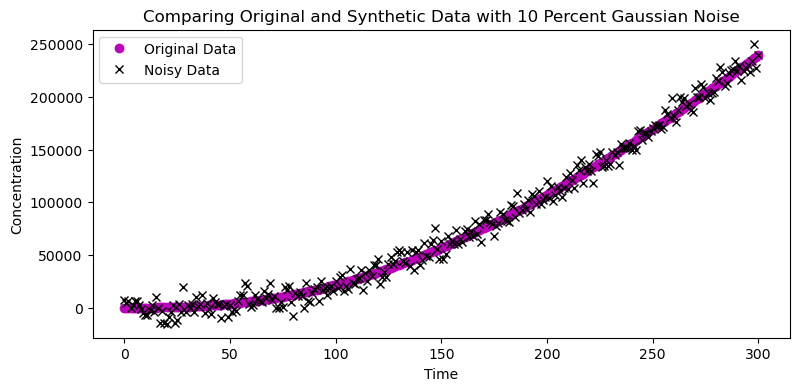

In [42]:
plt.figure(figsize=(9,4), dpi=100)
plt.plot(tsNoise, trajsNoise, 'om', label = "Original Data")
plt.plot(tsNoise, tenPercentNoise, 'kx', label = "Noisy Data")

plt.legend()
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('Comparing Original and Synthetic Data with 10 Percent Gaussian Noise')

In [43]:
df = pd.DataFrame()
df['time'] = tsNoise
df['nNFkB'] = tenPercentNoise
df.to_csv('tenPercNoise_NFkB_data.csv', index=False)

only t = 50 with 100 points 

In [4]:
# model system params
NFkB_SBML = "shortTime.xml" # name of sbml file 
# species = ["nNFKB", "cNFKB", "cikba", "Ccomplex", "nikba", "ncomplex", "ikkN", "ikka", "TNFR_a", "TNFR_i", "TNF"] # names of observables in order from bngl file, also in smbl under "dependent variables / observables"
species = ["TNF", "TNFRi", "TNFRa", "IKKi", "IKKa", "cNFKB", "nNFKB", "cIkB", "nIkB", "cNFkB_IkB", "nNFkB_IkB", "A20"] # names of observables in order from bngl file, also in smbl under "dependent variables / observables"

speciesID = ["S1", "S2", "S3", "S4", "S5", "S6", "S7", "S8", "S9", "S10", "S11", "S12"] # these are the IDs created from the sbml file 
time = 50 # t_end from bngl 
SPECIES_COLORS = ["tab:pink", "tab:purple", "tab:cyan", "tab:blue", "tab:orange", "tab:green", "tab:red", "tab:gray", "tab:brown", "tab:olive", "black", "y"]
# params = ["k_b", "k_f", "k_a", "k_4", "ka1a", "kd1a", "ki1", "ke1", "ki2", "ke2", "ke2a", "c4a", "c5a", "kt1a", "kt2a", "c1a"] # names of parameters in order from bngl file 
params = ["LOG_k_b", "LOG_k_f", "LOG_k_a", "LOG_k_4", "LOG_k_i1", "LOG_k_e1", "LOG_k_t2a", "LOG_k_t1a", "LOG_k_i2", "LOG_k_e2", "LOG_k_e2a", "LOG_c_4a", "LOG_c_5a", "LOG_c_1a", "LOG_k_a1a", "LOG_k_d1a", "LOG_c_3", "LOG_c_1", "LOG_k_ikk", "LOG_k_tnfr", "LOG_TNFRin", "LOG_IKKin", "LOG_boundc"] # names of parameters in order from bngl file 

# synthetic data params
gausNoise = 0.01 # 1% gausian noise, should it be 10% noise? i do 10 later
points = 100 # not sure yet 

# optimizaiton params 
logError = False

In [5]:
NFkB_SBML = "shortTime.xml" # name of sbml file
rr = roadrunner.RoadRunner(NFkB_SBML) # uses libroadrunner to load the sbml file for the mRNA model 
# integrator is a numerical ODE solver
# abs and rel tolerance are parameters controlling error tolerence of the solution
rr.integrator.absolute_tolerance = 5e-12 # in absolute terms:  small value increases accuracy but slower
rr.integrator.relative_tolerance = 1e-12 # rel terms (proportion of value being calc): small val inc acc

# list of the true parameter values 
trueParams = [rr[params[0]], rr[params[1]], rr[params[2]], rr[params[3]], rr[params[4]], rr[params[5]], rr[params[6]], rr[params[7]], rr[params[8]], rr[params[9]], rr[params[10]], rr[params[11]],rr[params[12]], rr[params[13]], rr[params[14]], rr[params[15]]] ,rr[params[16]], rr[params[17]], rr[params[18]], rr[params[19]], rr[params[20]], rr[params[21]], rr[params[22]]


In [6]:
rr.resetAll() # reset everything so we can start over and use our noisy data 

# simulates model from 0 to time with # of points
# in res: first col rep time points, other cols rep the trajectories (value over time) of species in model 
simData = rr.simulate(0, time, points)  
tsSim = simData[:,0] # first col in res is the time points 
print(tsSim)
trajsSim = simData[:,7] # the second col bc we want the mRNA concentration
print(trajsSim)

[ 0.          0.50505051  1.01010101  1.51515152  2.02020202  2.52525253
  3.03030303  3.53535354  4.04040404  4.54545455  5.05050505  5.55555556
  6.06060606  6.56565657  7.07070707  7.57575758  8.08080808  8.58585859
  9.09090909  9.5959596  10.1010101  10.60606061 11.11111111 11.61616162
 12.12121212 12.62626263 13.13131313 13.63636364 14.14141414 14.64646465
 15.15151515 15.65656566 16.16161616 16.66666667 17.17171717 17.67676768
 18.18181818 18.68686869 19.19191919 19.6969697  20.2020202  20.70707071
 21.21212121 21.71717172 22.22222222 22.72727273 23.23232323 23.73737374
 24.24242424 24.74747475 25.25252525 25.75757576 26.26262626 26.76767677
 27.27272727 27.77777778 28.28282828 28.78787879 29.29292929 29.7979798
 30.3030303  30.80808081 31.31313131 31.81818182 32.32323232 32.82828283
 33.33333333 33.83838384 34.34343434 34.84848485 35.35353535 35.85858586
 36.36363636 36.86868687 37.37373737 37.87878788 38.38383838 38.88888889
 39.39393939 39.8989899  40.4040404  40.90909091 41.

In [7]:
df = pd.DataFrame()
df['time'] = tsSim
df['nNFkB'] = trajsSim
df.to_csv('shortTime.csv', index=False)